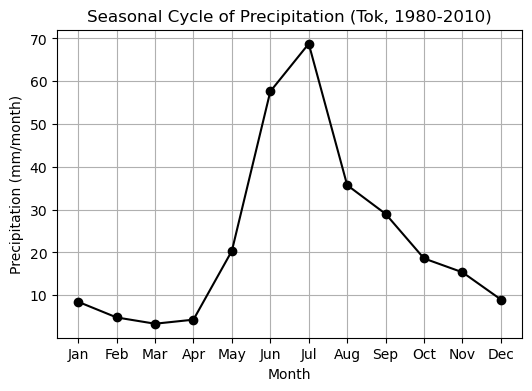

In [8]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# File path for historical precipitation data
file_path = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp45.nc"

# Location of Tok
tok = {"name": "Tok", "lon": -142.8089, "lat": 63.3286}

# Open dataset
ds = xr.open_dataset(file_path)

# Ensure time is in datetime format
ds["time"] = pd.to_datetime(ds["time"].values)

# Extract month and year
ds = ds.assign_coords(month=ds["time"].dt.month, year=ds["time"].dt.year)

# Define historical period (1980-2010)
hist_ds = ds.sel(time=slice("1980-01-01", "2010-12-31"))

# Extract latitude and longitude for the first time step (since they are 3D)
lats = hist_ds["latitude"].isel(time=0)
lons = hist_ds["longitude"].isel(time=0)

# Compute distances to Tok's location
dist = np.sqrt((lons - tok["lon"])**2 + (lats - tok["lat"])**2)
y_idx, x_idx = np.unravel_index(dist.argmin(), dist.shape)

# Extract precipitation data at the nearest grid cell
precip_data = hist_ds["PRCP"].isel(y=y_idx, x=x_idx)

# Compute mean seasonal cycle
seasonal_cycle = precip_data.groupby("month").mean(dim="time")

# Plot
plt.figure(figsize=(6, 4))
plt.plot(seasonal_cycle["month"], seasonal_cycle, marker="o", linestyle="-", color="black")
plt.xlabel("Month")
plt.ylabel("Precipitation (mm/month)")
plt.title("Seasonal Cycle of Precipitation (Tok, 1980-2010)")
plt.grid(True)
plt.xticks(np.arange(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()


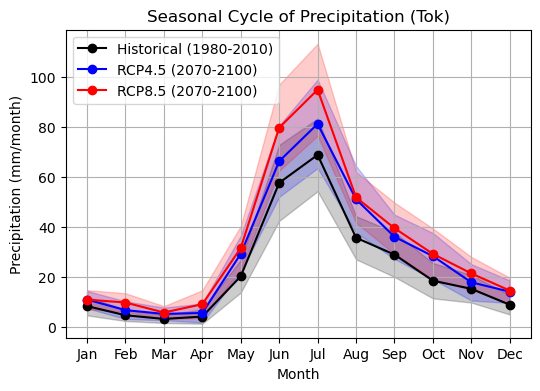

In [9]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# File paths for historical and future projections
file_hist = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp45.nc"
file_rcp45 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp45.nc"
file_rcp85 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp85.nc"

# Location of Tok
tok = {"name": "Tok", "lon": -142.8089, "lat": 63.3286}

# Function to extract seasonal cycle and uncertainty
def extract_seasonal_cycle(file_path, start_year, end_year):
    # Open dataset
    ds = xr.open_dataset(file_path)
    
    # Convert time to datetime
    ds["time"] = pd.to_datetime(ds["time"].values)

    # Extract month and year
    ds = ds.assign_coords(month=ds["time"].dt.month, year=ds["time"].dt.year)

    # Select time period
    ds_period = ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))

    # Extract latitude and longitude (first time slice since they are 3D)
    lats = ds_period["latitude"].isel(time=0)
    lons = ds_period["longitude"].isel(time=0)

    # Compute distance to Tok
    dist = np.sqrt((lons - tok["lon"])**2 + (lats - tok["lat"])**2)
    y_idx, x_idx = np.unravel_index(dist.argmin(), dist.shape)

    # Extract precipitation data at the nearest grid cell
    precip_data = ds_period["PRCP"].isel(y=y_idx, x=x_idx)

    # Compute mean and std deviation seasonal cycle
    seasonal_mean = precip_data.groupby("month").mean(dim="time")
    seasonal_std = precip_data.groupby("month").std(dim="time")

    return seasonal_mean, seasonal_std

# Extract seasonal cycles
hist_mean, hist_std = extract_seasonal_cycle(file_hist, 1980, 2010)
rcp45_mean, rcp45_std = extract_seasonal_cycle(file_rcp45, 2070, 2100)
rcp85_mean, rcp85_std = extract_seasonal_cycle(file_rcp85, 2070, 2100)

# Plot
plt.figure(figsize=(6, 4))

# Historical period (Black)
plt.plot(hist_mean["month"], hist_mean, marker="o", linestyle="-", color="black", label="Historical (1980-2010)")
plt.fill_between(hist_mean["month"], hist_mean - hist_std, hist_mean + hist_std, color="black", alpha=0.2)

# RCP4.5 (Blue)
plt.plot(rcp45_mean["month"], rcp45_mean, marker="o", linestyle="-", color="blue", label="RCP4.5 (2070-2100)")
plt.fill_between(rcp45_mean["month"], rcp45_mean - rcp45_std, rcp45_mean + rcp45_std, color="blue", alpha=0.2)

# RCP8.5 (Red)
plt.plot(rcp85_mean["month"], rcp85_mean, marker="o", linestyle="-", color="red", label="RCP8.5 (2070-2100)")
plt.fill_between(rcp85_mean["month"], rcp85_mean - rcp85_std, rcp85_mean + rcp85_std, color="red", alpha=0.2)

# Labels and formatting
plt.xlabel("Month")
plt.ylabel("Precipitation (mm/month)")
plt.title("Seasonal Cycle of Precipitation (Tok)")
plt.grid(True)
plt.xticks(np.arange(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend()
plt.show()


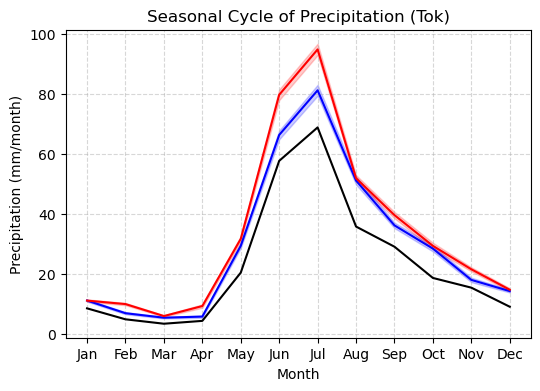

In [15]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# File paths for historical and future projections
file_hist = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp45.nc"
file_rcp45 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp45.nc"
file_rcp85 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp85.nc"

# Location of Tok
tok = {"name": "Tok", "lon": -142.8089, "lat": 63.3286}

# Function to extract seasonal cycle and compute 95% CI
def extract_seasonal_cycle(file_path, start_year, end_year):
    """Extracts mean monthly precipitation and computes 95% CI."""
    ds = xr.open_dataset(file_path)
    
    # Convert time to datetime
    ds["time"] = pd.to_datetime(ds["time"].values)

    # Extract month and year
    ds = ds.assign_coords(month=ds["time"].dt.month, year=ds["time"].dt.year)

    # Select time period
    ds_period = ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))

    # Extract latitude and longitude (first time slice since they are 3D)
    lats = ds_period["latitude"].isel(time=0)
    lons = ds_period["longitude"].isel(time=0)

    # Compute distance to Tok
    dist = np.sqrt((lons - tok["lon"])**2 + (lats - tok["lat"])**2)
    y_idx, x_idx = np.unravel_index(dist.argmin(), dist.shape)

    # Extract precipitation data at the nearest grid cell
    precip_data = ds_period["PRCP"].isel(y=y_idx, x=x_idx)

    # Compute mean seasonal cycle
    seasonal_mean = precip_data.groupby("month").mean(dim="time")

    # Compute 95% confidence interval (1.96 * std / sqrt(n))
    seasonal_std = precip_data.groupby("month").std(dim="time")
    n = ds_period.sizes["time"]
    seasonal_ci95 = 1.96 * (seasonal_std / np.sqrt(n))

    return seasonal_mean, seasonal_ci95

# Extract seasonal cycles
hist_mean, _ = extract_seasonal_cycle(file_hist, 1980, 2010)  # No uncertainty shading needed
rcp45_mean, rcp45_ci95 = extract_seasonal_cycle(file_rcp45, 2070, 2100)
rcp85_mean, rcp85_ci95 = extract_seasonal_cycle(file_rcp85, 2070, 2100)

# Plot
plt.figure(figsize=(6, 4))

# Historical period (Black, no uncertainty shading)
plt.plot(hist_mean["month"], hist_mean, linestyle="-", color="black", label="Historical (1980-2010)")

# RCP4.5 (Blue) with 95% CI shading
plt.plot(rcp45_mean["month"], rcp45_mean, linestyle="-", color="blue", label="RCP4.5 (2070-2100)")
plt.fill_between(rcp45_mean["month"], rcp45_mean - rcp45_ci95, rcp45_mean + rcp45_ci95, color="blue", alpha=0.2)

# RCP8.5 (Red) with 95% CI shading
plt.plot(rcp85_mean["month"], rcp85_mean, linestyle="-", color="red", label="RCP8.5 (2070-2100)")
plt.fill_between(rcp85_mean["month"], rcp85_mean - rcp85_ci95, rcp85_mean + rcp85_ci95, color="red", alpha=0.2)

# Labels and formatting
plt.xlabel("Month")
plt.ylabel("Precipitation (mm/month)")
plt.title("Seasonal Cycle of Precipitation (Tok)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(np.arange(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
#plt.legend()
plt.show()


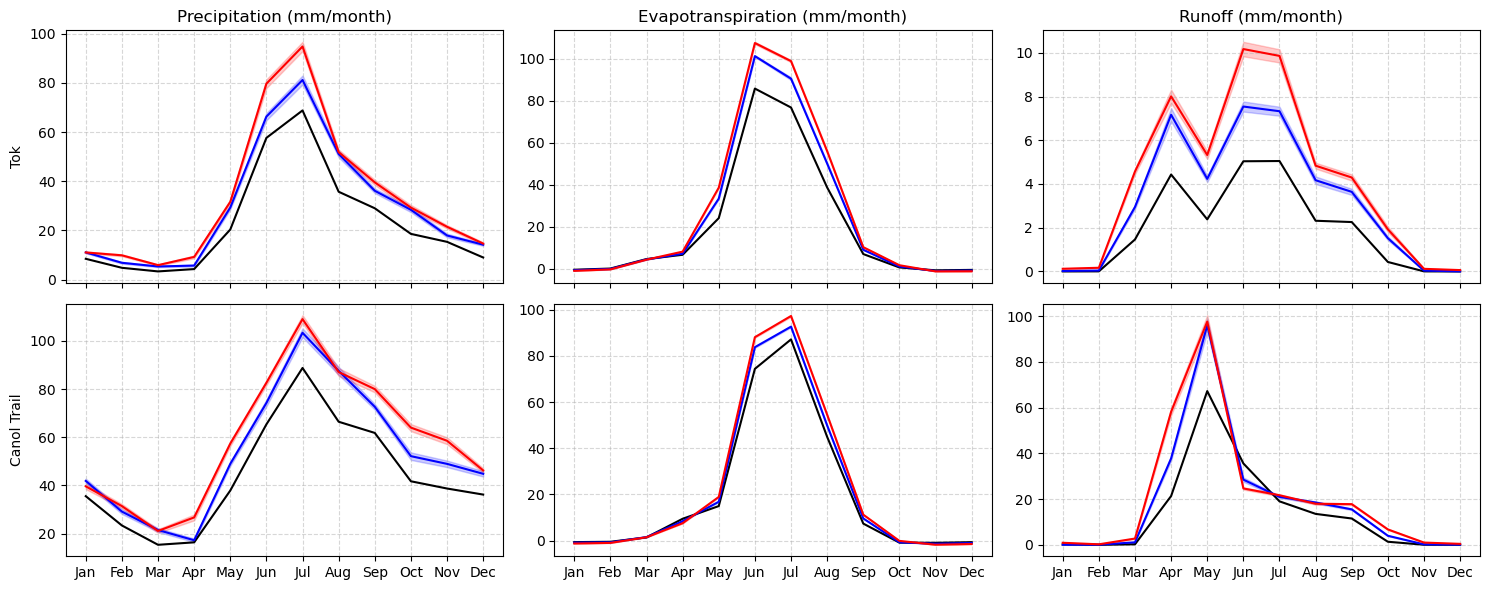

In [19]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# File paths for historical and future projections
file_hist = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp45.nc"
file_rcp45 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp45.nc"
file_rcp85 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp85.nc"

# Locations
sites = {
    "Tok": {"lon": -142.8089, "lat": 63.3286},
    "Canol Trail": {"lon": -134.95, "lat": 64.033}
}

# Variables
variables = {
    "PRCP": "Precipitation (mm/month)",
    "EVAP": "Evapotranspiration (mm/month)",
    "RUNOFF": "Runoff (mm/month)",
    #"dSM": "Δ Soil Moisture (mm)",
    #"dSWE": "Δ Snow Water Equivalent (mm)",
    #"dIWE": "Δ Ice Water Equivalent (mm)"
}

# Function to extract seasonal cycle and compute 95% CI
def extract_seasonal_cycle(file_path, var_name, site, start_year, end_year):
    """Extracts mean monthly variable and computes 95% CI."""
    ds = xr.open_dataset(file_path)
    
    # Convert time to datetime
    ds["time"] = pd.to_datetime(ds["time"].values)

    # Extract month and year
    ds = ds.assign_coords(month=ds["time"].dt.month, year=ds["time"].dt.year)

    # Select time period
    ds_period = ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))

    # Extract latitude and longitude (first time slice since they are 3D)
    lats = ds_period["latitude"].isel(time=0)
    lons = ds_period["longitude"].isel(time=0)

    # Compute distance to site
    dist = np.sqrt((lons - site["lon"])**2 + (lats - site["lat"])**2)
    y_idx, x_idx = np.unravel_index(dist.argmin(), dist.shape)

    # Extract data at the nearest grid cell
    data = ds_period[var_name].isel(y=y_idx, x=x_idx)

    # Compute mean seasonal cycle
    seasonal_mean = data.groupby("month").mean(dim="time")

    # Compute 95% confidence interval (1.96 * std / sqrt(n))
    seasonal_std = data.groupby("month").std(dim="time")
    n = ds_period.sizes["time"]
    seasonal_ci95 = 1.96 * (seasonal_std / np.sqrt(n))

    return seasonal_mean, seasonal_ci95

# Create figure
fig, axes = plt.subplots(nrows=2, ncols=len(variables), figsize=(15, 6), sharex=True)

# Loop through sites and variables
for row, (site_name, site) in enumerate(sites.items()):
    for col, (var, var_label) in enumerate(variables.items()):
        ax = axes[row, col]

        # Extract seasonal cycles
        hist_mean, _ = extract_seasonal_cycle(file_hist, var, site, 1980, 2010)  # No uncertainty shading needed
        rcp45_mean, rcp45_ci95 = extract_seasonal_cycle(file_rcp45, var, site, 2070, 2100)
        rcp85_mean, rcp85_ci95 = extract_seasonal_cycle(file_rcp85, var, site, 2070, 2100)

        # Plot historical (Black, no uncertainty shading)
        ax.plot(hist_mean["month"], hist_mean, linestyle="-", color="black", label="Hist (1980-2010)")

        # Plot RCP4.5 (Blue) with 95% CI shading
        ax.plot(rcp45_mean["month"], rcp45_mean, linestyle="-", color="blue", label="RCP4.5 (2070-2100)")
        ax.fill_between(rcp45_mean["month"], rcp45_mean - rcp45_ci95, rcp45_mean + rcp45_ci95, color="blue", alpha=0.2)

        # Plot RCP8.5 (Red) with 95% CI shading
        ax.plot(rcp85_mean["month"], rcp85_mean, linestyle="-", color="red", label="RCP8.5 (2070-2100)")
        ax.fill_between(rcp85_mean["month"], rcp85_mean - rcp85_ci95, rcp85_mean + rcp85_ci95, color="red", alpha=0.2)

        # Formatting
        ax.set_title(var_label if row == 0 else "")  # Title only for first row
        ax.set_ylabel(site_name if col == 0 else "")  # Label site on first column
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.set_xticks(np.arange(1, 13))
        ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

# Adjust layout
plt.tight_layout()
plt.show()


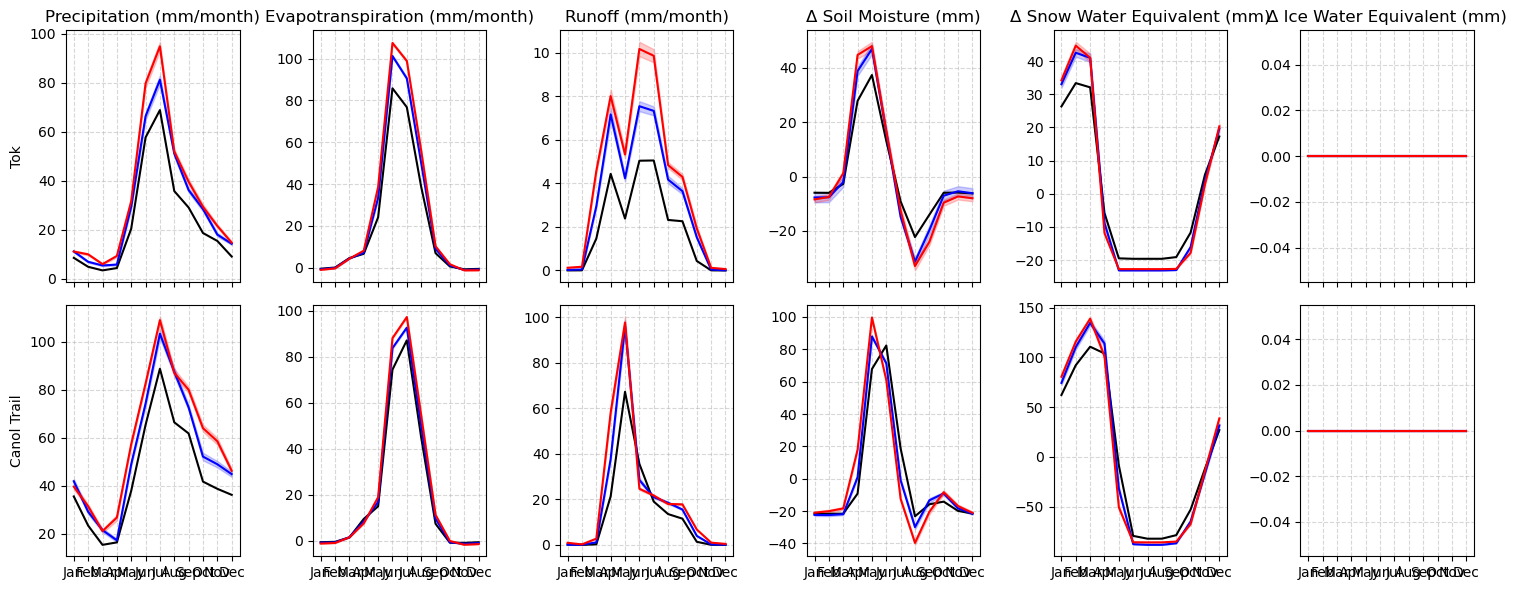

In [21]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# File paths for historical and future projections
file_ws_hist = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_ws_rcp45.nc"
file_ws_rcp45 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_ws_rcp45.nc"
file_ws_rcp85 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_ws_rcp85.nc"

file_wf_hist = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp45.nc"
file_wf_rcp45 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp45.nc"
file_wf_rcp85 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp85.nc"

# Locations
sites = {
    "Tok": {"lon": -142.8089, "lat": 63.3286},
    "Canol Trail": {"lon": -134.95, "lat": 64.033}
}

# Variables with file sources
variables = {
    "PRCP": ("Precipitation (mm/month)", file_wf_hist, file_wf_rcp45, file_wf_rcp85),
    "EVAP": ("Evapotranspiration (mm/month)", file_wf_hist, file_wf_rcp45, file_wf_rcp85),
    "RUNOFF": ("Runoff (mm/month)", file_wf_hist, file_wf_rcp45, file_wf_rcp85),
    "dSM": ("Δ Soil Moisture (mm)", file_ws_hist, file_ws_rcp45, file_ws_rcp85),
    "dSWE": ("Δ Snow Water Equivalent (mm)", file_ws_hist, file_ws_rcp45, file_ws_rcp85),
    "dIWE": ("Δ Ice Water Equivalent (mm)", file_ws_hist, file_ws_rcp45, file_ws_rcp85)
}

# Function to extract seasonal cycle and compute delta variables
def extract_seasonal_cycle(file_hist, file_rcp45, file_rcp85, var_name, site):
    """Extracts mean monthly variable and computes 95% CI for historical and future periods.
    If var_name is dSM, dSWE, or dIWE, computes monthly anomalies from the mean state."""

    def process_file(file_path, start_year, end_year, var_name):
        ds = xr.open_dataset(file_path)
        ds["time"] = pd.to_datetime(ds["time"].values)
        ds = ds.assign_coords(month=ds["time"].dt.month, year=ds["time"].dt.year)
        ds_period = ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))

        lats = ds_period["latitude"].isel(time=0)
        lons = ds_period["longitude"].isel(time=0)
        dist = np.sqrt((lons - site["lon"])**2 + (lats - site["lat"])**2)
        y_idx, x_idx = np.unravel_index(dist.argmin(), dist.shape)

        # Handle delta variables
        if var_name == "dSM":
            data = (ds_period["SM1"] + ds_period["SM2"] + ds_period["SM3"]).isel(y=y_idx, x=x_idx)
        elif var_name == "dSWE":
            data = ds_period["SWE"].isel(y=y_idx, x=x_idx)
        elif var_name == "dIWE":
            data = ds_period["IWE"].isel(y=y_idx, x=x_idx)
        else:
            data = ds_period[var_name].isel(y=y_idx, x=x_idx)

        # Compute mean seasonal cycle
        seasonal_mean = data.groupby("month").mean(dim="time")

        # If delta variable, compute difference from mean state
        if var_name in ["dSM", "dSWE", "dIWE"]:
            period_mean = data.mean(dim="time")  # Mean over entire period
            seasonal_mean = seasonal_mean - period_mean  # Anomaly

        # Compute 95% confidence interval
        seasonal_std = data.groupby("month").std(dim="time")
        n = ds_period.sizes["time"]
        seasonal_ci95 = 1.96 * (seasonal_std / np.sqrt(n))

        return seasonal_mean, seasonal_ci95

    # Extract historical and future seasonal cycles
    hist_mean, _ = process_file(file_hist, 1980, 2010, var_name)
    rcp45_mean, rcp45_ci95 = process_file(file_rcp45, 2070, 2100, var_name)
    rcp85_mean, rcp85_ci95 = process_file(file_rcp85, 2070, 2100, var_name)

    return hist_mean, rcp45_mean, rcp45_ci95, rcp85_mean, rcp85_ci95

# Create figure
fig, axes = plt.subplots(nrows=2, ncols=len(variables), figsize=(15, 6), sharex=True)

# Loop through sites and variables
for row, (site_name, site) in enumerate(sites.items()):
    for col, (var, (var_label, file_hist, file_rcp45, file_rcp85)) in enumerate(variables.items()):
        ax = axes[row, col]

        # Extract seasonal cycles
        hist_mean, rcp45_mean, rcp45_ci95, rcp85_mean, rcp85_ci95 = extract_seasonal_cycle(
            file_hist, file_rcp45, file_rcp85, var, site
        )

        # Plot historical (Black, no uncertainty shading)
        ax.plot(hist_mean["month"], hist_mean, linestyle="-", color="black", label="Hist (1980-2010)")

        # Plot RCP4.5 (Blue) with 95% CI shading
        ax.plot(rcp45_mean["month"], rcp45_mean, linestyle="-", color="blue", label="RCP4.5 (2070-2100)")
        ax.fill_between(rcp45_mean["month"], rcp45_mean - rcp45_ci95, rcp45_mean + rcp45_ci95, color="blue", alpha=0.2)

        # Plot RCP8.5 (Red) with 95% CI shading
        ax.plot(rcp85_mean["month"], rcp85_mean, linestyle="-", color="red", label="RCP8.5 (2070-2100)")
        ax.fill_between(rcp85_mean["month"], rcp85_mean - rcp85_ci95, rcp85_mean + rcp85_ci95, color="red", alpha=0.2)

        # Formatting
        ax.set_title(var_label if row == 0 else "")  # Title only for first row
        ax.set_ylabel(site_name if col == 0 else "")  # Label site on first column
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.set_xticks(np.arange(1, 13))
        ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

# Adjust layout
plt.tight_layout()
plt.show()


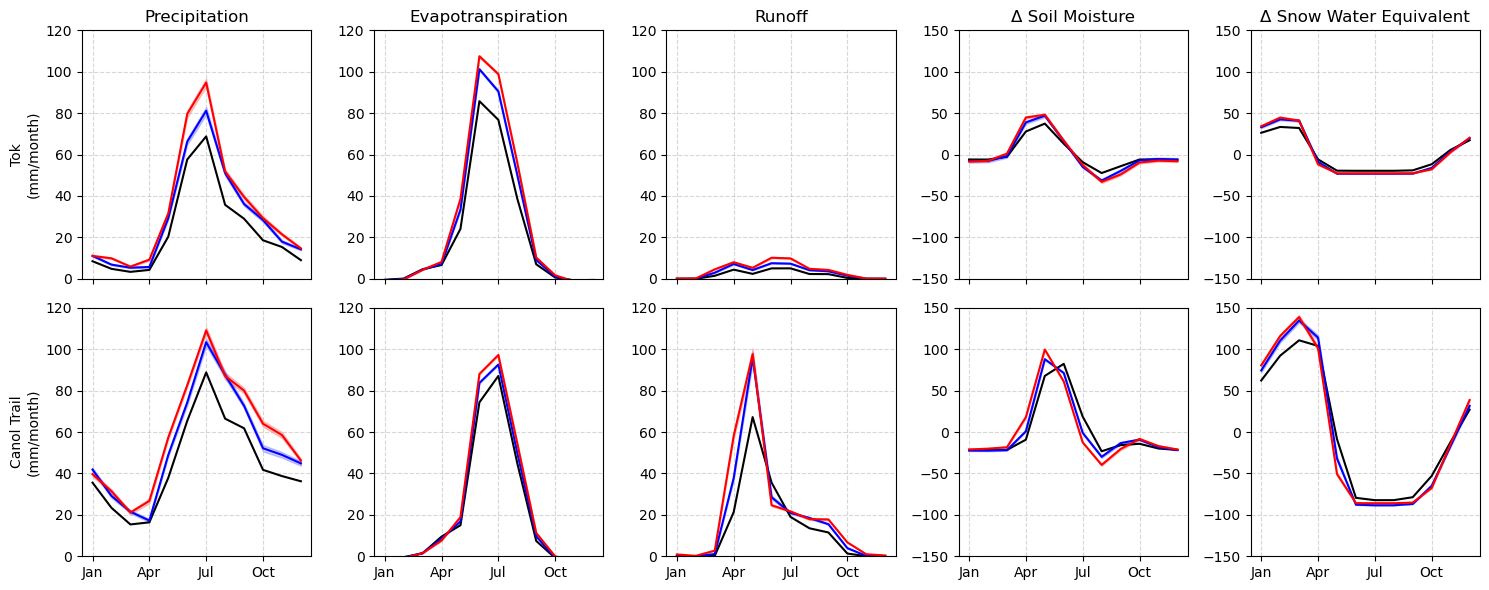

In [24]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# File paths for historical and future projections
file_ws_hist = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_ws_rcp45.nc"
file_ws_rcp45 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_ws_rcp45.nc"
file_ws_rcp85 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_ws_rcp85.nc"

file_wf_hist = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp45.nc"
file_wf_rcp45 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp45.nc"
file_wf_rcp85 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp85.nc"

# Locations
sites = {
    "Tok\n(mm/month)": {"lon": -142.8089, "lat": 63.3286},
    "Canol Trail\n(mm/month)": {"lon": -134.95, "lat": 64.033}
}

# Variables with file sources
variables = {
    "PRCP": ("Precipitation", file_wf_hist, file_wf_rcp45, file_wf_rcp85),
    "EVAP": ("Evapotranspiration", file_wf_hist, file_wf_rcp45, file_wf_rcp85),
    "RUNOFF": ("Runoff", file_wf_hist, file_wf_rcp45, file_wf_rcp85),
    "dSM": ("Δ Soil Moisture", file_ws_hist, file_ws_rcp45, file_ws_rcp85),
    "dSWE": ("Δ Snow Water Equivalent", file_ws_hist, file_ws_rcp45, file_ws_rcp85),
    #"dIWE": ("Δ Ice Water Equivalent", file_ws_hist, file_ws_rcp45, file_ws_rcp85)
}

# Function to extract seasonal cycle and compute delta variables
def extract_seasonal_cycle(file_hist, file_rcp45, file_rcp85, var_name, site):
    """Extracts mean monthly variable and computes 95% CI for historical and future periods.
    If var_name is dSM, dSWE, or dIWE, computes monthly anomalies from the mean state."""

    def process_file(file_path, start_year, end_year, var_name):
        ds = xr.open_dataset(file_path)
        ds["time"] = pd.to_datetime(ds["time"].values)
        ds = ds.assign_coords(month=ds["time"].dt.month, year=ds["time"].dt.year)
        ds_period = ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))

        lats = ds_period["latitude"].isel(time=0)
        lons = ds_period["longitude"].isel(time=0)
        dist = np.sqrt((lons - site["lon"])**2 + (lats - site["lat"])**2)
        y_idx, x_idx = np.unravel_index(dist.argmin(), dist.shape)

        # Handle delta variables
        if var_name == "dSM":
            data = (ds_period["SM1"] + ds_period["SM2"] + ds_period["SM3"]).isel(y=y_idx, x=x_idx)
        elif var_name == "dSWE":
            data = ds_period["SWE"].isel(y=y_idx, x=x_idx)
        elif var_name == "dIWE":
            data = ds_period["IWE"].isel(y=y_idx, x=x_idx)
        else:
            data = ds_period[var_name].isel(y=y_idx, x=x_idx)

        # Compute mean seasonal cycle
        seasonal_mean = data.groupby("month").mean(dim="time")

        # If delta variable, compute difference from mean state
        if var_name in ["dSM", "dSWE", "dIWE"]:
            period_mean = data.mean(dim="time")  # Mean over entire period
            seasonal_mean = seasonal_mean - period_mean  # Anomaly

        # Compute 95% confidence interval
        seasonal_std = data.groupby("month").std(dim="time")
        n = ds_period.sizes["time"]
        seasonal_ci95 = 1.96 * (seasonal_std / np.sqrt(n))

        return seasonal_mean, seasonal_ci95

    # Extract historical and future seasonal cycles
    hist_mean, _ = process_file(file_hist, 1980, 2010, var_name)
    rcp45_mean, rcp45_ci95 = process_file(file_rcp45, 2070, 2100, var_name)
    rcp85_mean, rcp85_ci95 = process_file(file_rcp85, 2070, 2100, var_name)

    return hist_mean, rcp45_mean, rcp45_ci95, rcp85_mean, rcp85_ci95

# Create figure
fig, axes = plt.subplots(nrows=2, ncols=len(variables), figsize=(15, 6), sharex=True)

# Loop through sites and variables
for row, (site_name, site) in enumerate(sites.items()):
    for col, (var, (var_label, file_hist, file_rcp45, file_rcp85)) in enumerate(variables.items()):
        ax = axes[row, col]

        # Extract seasonal cycles
        hist_mean, rcp45_mean, rcp45_ci95, rcp85_mean, rcp85_ci95 = extract_seasonal_cycle(
            file_hist, file_rcp45, file_rcp85, var, site
        )

        # Plot historical (Black, no uncertainty shading)
        ax.plot(hist_mean["month"], hist_mean, linestyle="-", color="black", label="Hist (1980-2010)")

        # Plot RCP4.5 (Blue) with 95% CI shading
        ax.plot(rcp45_mean["month"], rcp45_mean, linestyle="-", color="blue", label="RCP4.5 (2070-2100)")
        ax.fill_between(rcp45_mean["month"], rcp45_mean - rcp45_ci95, rcp45_mean + rcp45_ci95, color="blue", alpha=0.2)

        # Plot RCP8.5 (Red) with 95% CI shading
        ax.plot(rcp85_mean["month"], rcp85_mean, linestyle="-", color="red", label="RCP8.5 (2070-2100)")
        ax.fill_between(rcp85_mean["month"], rcp85_mean - rcp85_ci95, rcp85_mean + rcp85_ci95, color="red", alpha=0.2)

        # Formatting
        ax.set_title(var_label if row == 0 else "")  # Title only for first row
        ax.set_ylabel(site_name if col == 0 else "")  # Label site on first column
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.set_xticks([1, 4, 7, 10])
        ax.set_xticklabels(["Jan", "Apr", "Jul", "Oct"])

        # Adjust y-axis limits
        if var in ["PRCP", "EVAP", "RUNOFF"]:
            ax.set_ylim(0, 120)
        elif var in ["dSM", "dSWE", "dIWE"]:
            ax.set_ylim(-150, 150)

# Adjust layout
plt.tight_layout()
plt.show()


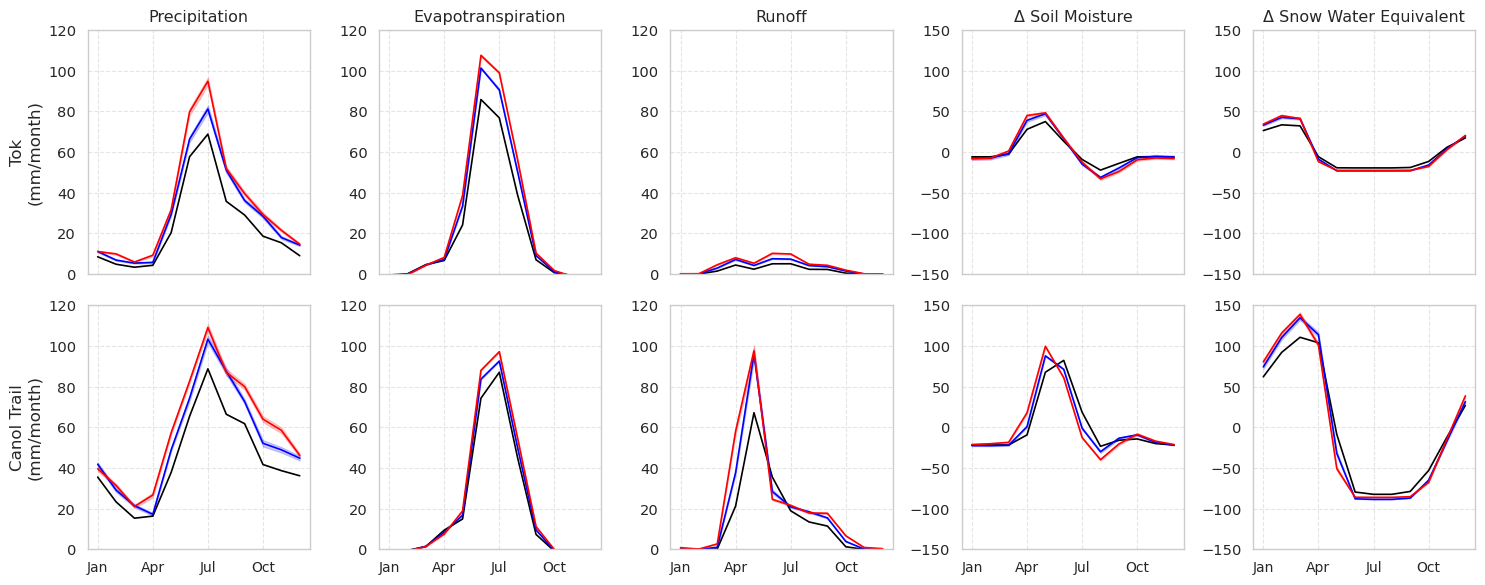

In [27]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set publication-style aesthetics
sns.set_context("paper", font_scale=1.2)
sns.set_style("whitegrid")

# File paths for historical and future projections
file_ws_hist = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_ws_rcp45.nc"
file_ws_rcp45 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_ws_rcp45.nc"
file_ws_rcp85 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_ws_rcp85.nc"

file_wf_hist = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp45.nc"
file_wf_rcp45 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp45.nc"
file_wf_rcp85 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp85.nc"

# Locations
sites = {
    "Tok\n(mm/month)": {"lon": -142.8089, "lat": 63.3286},
    "Canol Trail\n(mm/month)": {"lon": -134.95, "lat": 64.033}
}

# Variables with file sources
variables = {
    "PRCP": ("Precipitation", file_wf_hist, file_wf_rcp45, file_wf_rcp85),
    "EVAP": ("Evapotranspiration", file_wf_hist, file_wf_rcp45, file_wf_rcp85),
    "RUNOFF": ("Runoff", file_wf_hist, file_wf_rcp45, file_wf_rcp85),
    "dSM": ("Δ Soil Moisture", file_ws_hist, file_ws_rcp45, file_ws_rcp85),
    "dSWE": ("Δ Snow Water Equivalent", file_ws_hist, file_ws_rcp45, file_ws_rcp85),
}

# Function to extract seasonal cycle and compute delta variables
def extract_seasonal_cycle(file_hist, file_rcp45, file_rcp85, var_name, site):
    """Extracts mean monthly variable and computes 95% CI for historical and future periods.
    If var_name is dSM, dSWE, or dIWE, computes monthly anomalies from the mean state."""

    def process_file(file_path, start_year, end_year, var_name):
        ds = xr.open_dataset(file_path)
        ds["time"] = pd.to_datetime(ds["time"].values)
        ds = ds.assign_coords(month=ds["time"].dt.month, year=ds["time"].dt.year)
        ds_period = ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))

        lats = ds_period["latitude"].isel(time=0)
        lons = ds_period["longitude"].isel(time=0)
        dist = np.sqrt((lons - site["lon"])**2 + (lats - site["lat"])**2)
        y_idx, x_idx = np.unravel_index(dist.argmin(), dist.shape)

        # Handle delta variables
        if var_name == "dSM":
            data = (ds_period["SM1"] + ds_period["SM2"] + ds_period["SM3"]).isel(y=y_idx, x=x_idx)
        elif var_name == "dSWE":
            data = ds_period["SWE"].isel(y=y_idx, x=x_idx)
        else:
            data = ds_period[var_name].isel(y=y_idx, x=x_idx)

        # Compute mean seasonal cycle
        seasonal_mean = data.groupby("month").mean(dim="time")

        # If delta variable, compute difference from mean state
        if var_name in ["dSM", "dSWE"]:
            period_mean = data.mean(dim="time")  # Mean over entire period
            seasonal_mean = seasonal_mean - period_mean  # Anomaly

        # Compute 95% confidence interval
        seasonal_std = data.groupby("month").std(dim="time")
        n = ds_period.sizes["time"]
        seasonal_ci95 = 1.96 * (seasonal_std / np.sqrt(n))

        return seasonal_mean, seasonal_ci95

    # Extract historical and future seasonal cycles
    hist_mean, _ = process_file(file_hist, 1980, 2010, var_name)
    rcp45_mean, rcp45_ci95 = process_file(file_rcp45, 2070, 2100, var_name)
    rcp85_mean, rcp85_ci95 = process_file(file_rcp85, 2070, 2100, var_name)

    return hist_mean, rcp45_mean, rcp45_ci95, rcp85_mean, rcp85_ci95

# Create figure
fig, axes = plt.subplots(nrows=2, ncols=len(variables), figsize=(15, 6), sharex=True)

# Loop through sites and variables
for row, (site_name, site) in enumerate(sites.items()):
    for col, (var, (var_label, file_hist, file_rcp45, file_rcp85)) in enumerate(variables.items()):
        ax = axes[row, col]

        # Extract seasonal cycles
        hist_mean, rcp45_mean, rcp45_ci95, rcp85_mean, rcp85_ci95 = extract_seasonal_cycle(
            file_hist, file_rcp45, file_rcp85, var, site
        )

        # Plot historical (Black, no uncertainty shading)
        ax.plot(hist_mean["month"], hist_mean, linestyle="-", color="black", label="Hist (1980-2010)")

        # Plot RCP4.5 (Blue) with 95% CI shading
        ax.plot(rcp45_mean["month"], rcp45_mean, linestyle="-", color="blue", label="RCP4.5 (2070-2100)")
        ax.fill_between(rcp45_mean["month"], rcp45_mean - rcp45_ci95, rcp45_mean + rcp45_ci95, color="blue", alpha=0.2)

        # Plot RCP8.5 (Red) with 95% CI shading
        ax.plot(rcp85_mean["month"], rcp85_mean, linestyle="-", color="red", label="RCP8.5 (2070-2100)")
        ax.fill_between(rcp85_mean["month"], rcp85_mean - rcp85_ci95, rcp85_mean + rcp85_ci95, color="red", alpha=0.2)

        # Formatting
        ax.set_title(var_label if row == 0 else "")  # Title only for first row
        ax.set_ylabel(site_name if col == 0 else "", fontsize=12)  # Label site on first column
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.set_xticks([1, 4, 7, 10])
        ax.set_xticklabels(["Jan", "Apr", "Jul", "Oct"], fontsize=10)

        # Adjust y-axis limits
        if var in ["PRCP", "EVAP", "RUNOFF"]:
            ax.set_ylim(0, 120)
        elif var in ["dSM", "dSWE"]:
            ax.set_ylim(-150, 150)

# Adjust layout
plt.tight_layout()

# Save as high-quality figures
#plt.savefig("seasonal_cycles.png", dpi=300, bbox_inches="tight")
plt.savefig("Fig2.pdf", dpi=300, bbox_inches="tight")

# Show figure
plt.show()


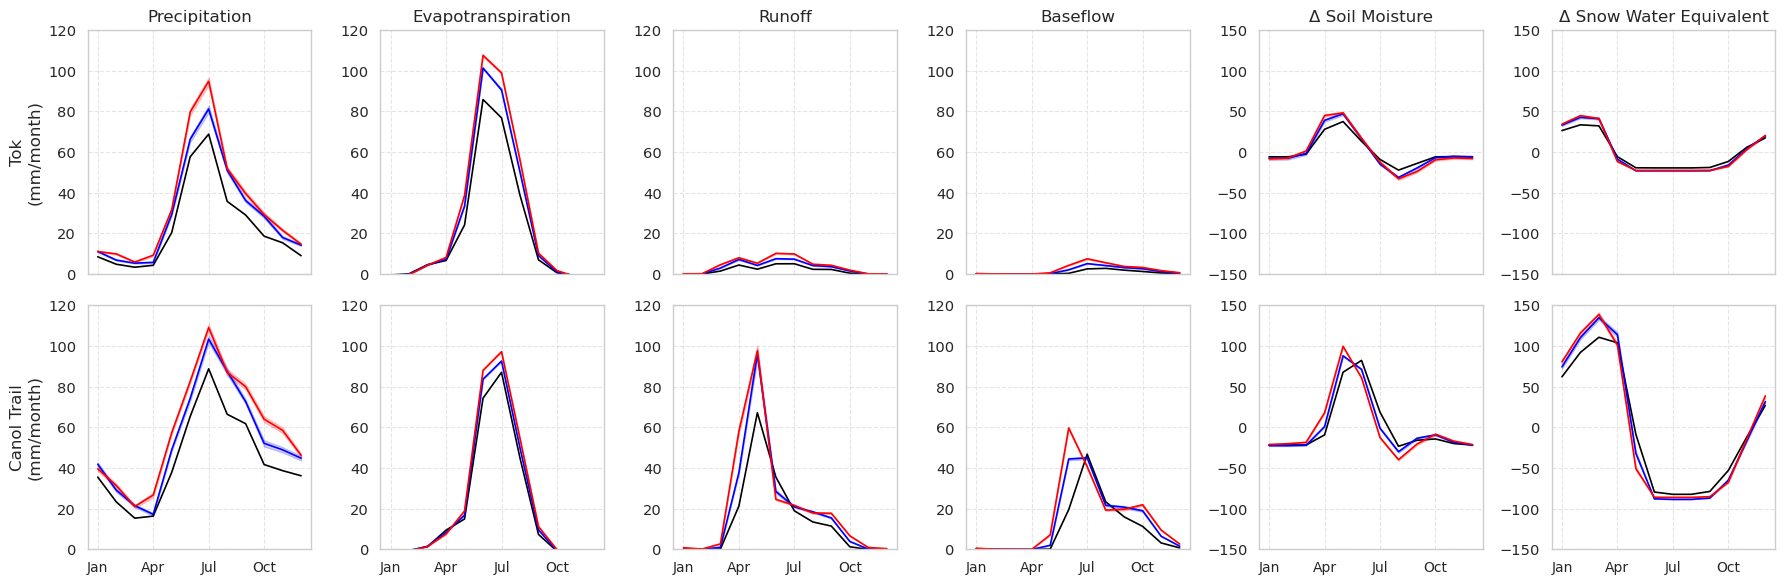

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set publication-style aesthetics
sns.set_context("paper", font_scale=1.2)
sns.set_style("whitegrid")

# File paths for historical and future projections
file_ws_hist = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_ws_rcp45.nc"
file_ws_rcp45 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_ws_rcp45.nc"
file_ws_rcp85 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_ws_rcp85.nc"

file_wf_hist = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp45.nc"
file_wf_rcp45 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp45.nc"
file_wf_rcp85 = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_wf_rcp85.nc"

# Locations
sites = {
    "Tok\n(mm/month)": {"lon": -142.8089, "lat": 63.3286},
    "Canol Trail\n(mm/month)": {"lon": -134.95, "lat": 64.033}
}

# Variables with file sources (including BASEFLOW)
variables = {
    "PRCP": ("Precipitation", file_wf_hist, file_wf_rcp45, file_wf_rcp85),
    "EVAP": ("Evapotranspiration", file_wf_hist, file_wf_rcp45, file_wf_rcp85),
    "RUNOFF": ("Runoff", file_wf_hist, file_wf_rcp45, file_wf_rcp85),
    "BASEFLOW": ("Baseflow", file_wf_hist, file_wf_rcp45, file_wf_rcp85),
    "dSM": ("Δ Soil Moisture", file_ws_hist, file_ws_rcp45, file_ws_rcp85),
    "dSWE": ("Δ Snow Water Equivalent", file_ws_hist, file_ws_rcp45, file_ws_rcp85),
}

# Function to extract seasonal cycle and compute delta variables
def extract_seasonal_cycle(file_hist, file_rcp45, file_rcp85, var_name, site):
    """Extracts mean monthly variable and computes 95% CI for historical and future periods.
    If var_name is dSM, dSWE, computes monthly anomalies from the mean state."""

    def process_file(file_path, start_year, end_year, var_name):
        ds = xr.open_dataset(file_path)
        ds["time"] = pd.to_datetime(ds["time"].values)
        ds = ds.assign_coords(month=ds["time"].dt.month, year=ds["time"].dt.year)
        ds_period = ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))

        lats = ds_period["latitude"].isel(time=0)
        lons = ds_period["longitude"].isel(time=0)
        dist = np.sqrt((lons - site["lon"])**2 + (lats - site["lat"])**2)
        y_idx, x_idx = np.unravel_index(dist.argmin(), dist.shape)

        # Handle delta variables
        if var_name == "dSM":
            data = (ds_period["SM1"] + ds_period["SM2"] + ds_period["SM3"]).isel(y=y_idx, x=x_idx)
        elif var_name == "dSWE":
            data = ds_period["SWE"].isel(y=y_idx, x=x_idx)
        else:
            data = ds_period[var_name].isel(y=y_idx, x=x_idx)

        # Compute mean seasonal cycle
        seasonal_mean = data.groupby("month").mean(dim="time")

        # If delta variable, compute difference from mean state
        if var_name in ["dSM", "dSWE"]:
            period_mean = data.mean(dim="time")  # Mean over entire period
            seasonal_mean = seasonal_mean - period_mean  # Anomaly

        # Compute 95% confidence interval
        seasonal_std = data.groupby("month").std(dim="time")
        n = ds_period.sizes["time"]
        seasonal_ci95 = 1.96 * (seasonal_std / np.sqrt(n))

        return seasonal_mean, seasonal_ci95

    # Extract historical and future seasonal cycles
    hist_mean, _ = process_file(file_hist, 1980, 2010, var_name)
    rcp45_mean, rcp45_ci95 = process_file(file_rcp45, 2070, 2100, var_name)
    rcp85_mean, rcp85_ci95 = process_file(file_rcp85, 2070, 2100, var_name)

    return hist_mean, rcp45_mean, rcp45_ci95, rcp85_mean, rcp85_ci95

# Create figure with an extra column for Baseflow
fig, axes = plt.subplots(nrows=2, ncols=len(variables), figsize=(18, 6), sharex=True)

# Loop through sites and variables
for row, (site_name, site) in enumerate(sites.items()):
    for col, (var, (var_label, file_hist, file_rcp45, file_rcp85)) in enumerate(variables.items()):
        ax = axes[row, col]

        # Extract seasonal cycles
        hist_mean, rcp45_mean, rcp45_ci95, rcp85_mean, rcp85_ci95 = extract_seasonal_cycle(
            file_hist, file_rcp45, file_rcp85, var, site
        )

        # Plot historical (Black, no uncertainty shading)
        ax.plot(hist_mean["month"], hist_mean, linestyle="-", color="black", label="Hist (1980-2010)")

        # Plot RCP4.5 (Blue) with 95% CI shading
        ax.plot(rcp45_mean["month"], rcp45_mean, linestyle="-", color="blue", label="RCP4.5 (2070-2100)")
        ax.fill_between(rcp45_mean["month"], rcp45_mean - rcp45_ci95, rcp45_mean + rcp45_ci95, color="blue", alpha=0.2)

        # Plot RCP8.5 (Red) with 95% CI shading
        ax.plot(rcp85_mean["month"], rcp85_mean, linestyle="-", color="red", label="RCP8.5 (2070-2100)")
        ax.fill_between(rcp85_mean["month"], rcp85_mean - rcp85_ci95, rcp85_mean + rcp85_ci95, color="red", alpha=0.2)

        # Formatting
        ax.set_title(var_label if row == 0 else "", fontsize=12)  # Title only for first row
        ax.set_ylabel(site_name if col == 0 else "", fontsize=12)  # Label site on first column
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.set_xticks([1, 4, 7, 10])
        ax.set_xticklabels(["Jan", "Apr", "Jul", "Oct"], fontsize=10)

        # Adjust y-axis limits
        if var in ["PRCP", "EVAP", "RUNOFF", "BASEFLOW"]:
            ax.set_ylim(0, 120)
        elif var in ["dSM", "dSWE"]:
            ax.set_ylim(-150, 150)

# Adjust layout
plt.tight_layout()

# Save as high-quality figures
plt.savefig("Fig2_A.pdf", dpi=300, bbox_inches="tight")

# Show figure
plt.show()
